In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import IPython
import IPython.display
import PIL
import os
print(os.listdir("../input"))

['train_curated.csv', 'train_curated', 'sample_submission.csv', 'train_noisy', 'train_noisy.csv', 'test']


In [2]:
DATA = Path('../input')
CSV_TRN_CURATED = DATA/'train_curated.csv'
CSV_TRN_NOISY = DATA/'train_noisy.csv'
CSV_SUBMISSION = DATA/'sample_submission.csv'
TRN_CURATED = DATA/'train_curated'
TRN_NOISY = DATA/'train_noisy'
TEST = DATA/'test'

WORK = Path('work')
IMG_TRN_CURATED = WORK/'image/trn_curated'
IMG_TRN_NOISY = WORK/'image/train_noisy'
IMG_TEST = WORK/'image/test'
for folder in [WORK, IMG_TRN_CURATED, IMG_TRN_NOISY, IMG_TEST]: 
    Path(folder).mkdir(exist_ok=True, parents=True)

df = pd.read_csv(CSV_TRN_CURATED)
test_df = pd.read_csv(CSV_SUBMISSION)

## Audio conversion to 2D Mels

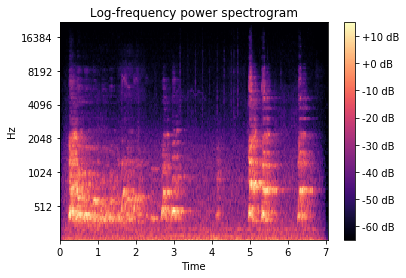

In [3]:
import librosa
import librosa.display

def read_audio(conf, pathname, trim_long_data):
    y, sr = librosa.load(pathname, sr=conf.sampling_rate)
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # trim, top_db=default(60)
    # make it unified length to conf.samples
    if len(y) > conf.samples: # long enough
        if trim_long_data:
            y = y[0:0+conf.samples]
    else: # pad blank
        padding = conf.samples - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, conf.samples - len(y) - offset), 'constant')
    return y

def audio_to_melspectrogram(conf, audio):
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=conf.sampling_rate,
                                                 n_mels=conf.n_mels,
                                                 hop_length=conf.hop_length,
                                                 n_fft=conf.n_fft,
                                                 fmin=conf.fmin,
                                                 fmax=conf.fmax)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram

def show_melspectrogram(conf, mels, title='Log-frequency power spectrogram'):
    librosa.display.specshow(mels, x_axis='time', y_axis='mel', 
                             sr=conf.sampling_rate, hop_length=conf.hop_length,
                            fmin=conf.fmin, fmax=conf.fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

def read_as_melspectrogram(conf, pathname, trim_long_data, debug_display=False):
    x = read_audio(conf, pathname, trim_long_data)
    mels = audio_to_melspectrogram(conf, x)
    if debug_display:
        IPython.display.display(IPython.display.Audio(x, rate=conf.sampling_rate))
        show_melspectrogram(conf, mels)
    return mels


class conf:
    # Preprocessing settings
    sampling_rate = 44100
    duration = 2
    hop_length = 347*duration # to make time steps 128
    fmin = 20
    fmax = sampling_rate // 2
    n_mels = 128
    n_fft = n_mels * 20
    samples = sampling_rate * duration

# example
x = read_as_melspectrogram(conf, TRN_CURATED/'0006ae4e.wav', trim_long_data=False, debug_display=True)

## Making 2D mel-spectrogram data as 2D 3ch images

In [4]:
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    Xstd = (X - mean) / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Scale to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V

def convert_wav_to_image(df, source, img_dest):
    X = []
    for i, row in tqdm_notebook(df.iterrows()):
        x = read_as_melspectrogram(conf, source/str(row.fname), trim_long_data=False)
        x_color = mono_to_color(x)
        X.append(x_color)
    return X

X_train = convert_wav_to_image(df, source=TRN_CURATED, img_dest=IMG_TRN_CURATED)
X_test = convert_wav_to_image(test_df, source=TEST, img_dest=IMG_TEST)

## Style Transfer

In [5]:
sample_rate = 44100     # частота дискретизации аудио
num_frequencies = 1025  # количество частот, которые будем извлекать
frame_length = 0.05     # длина окна STFT (в секундах)
frame_shift = 0.0125    # сдвиг окна STFT (в секундах)
num_mels = 80           # размерность mel-пространства признаков
min_frequency = 50      # минимальная анализируемая частота (в Гц)
max_frequency = 12000   # максимальная анализируемая частота (в Гц)

hop_length = int(sample_rate * frame_shift)
win_length = int(sample_rate * frame_length)
n_fft = (num_frequencies - 1) * 2

ref_db = 20
min_db = -100
PREEMPHASIS = 0.97
POWER = 1.2

In [6]:
# функции-обёртки для работы с комплесными спектрами

def stft(y):
    return librosa.stft(y, 
        n_fft=conf.n_fft, 
        hop_length=conf.hop_length)
        #win_length=win_length)

def istft(y):
    return librosa.istft(y, 
        hop_length=conf.hop_length) 
        #win_length=win_length)

In [7]:
# алгоритм Гриффин-Лим

def griffin_lim(S, num_iter=20):
    np.random.seed(42)
    
    Phi = np.random.uniform(0, 2 * np.pi, S.shape)
    H = S * np.exp(1.0j * Phi)
    
    for n in range(num_iter):
        Phi = np.angle(stft(istft(H)))
        H = S * np.exp(1.0j * Phi)
        
    return H

In [8]:
mel_basis = librosa.filters.mel(
    conf.sampling_rate, conf.n_fft, n_mels=conf.n_mels,
    fmin=conf.fmin, fmax=conf.fmax)
inv_mel_basis = np.linalg.pinv(mel_basis)

In [9]:
import scipy.signal

def mel_to_linear(M):
    S = np.dot(inv_mel_basis, M)
    return S

def inv_normalize(S):
    S = -min_db * (S - 1)
    return S

def db_to_amp(x):
    x = np.power(10, x / 20)
    return x

def de_emphasis(x):
    x = scipy.signal.lfilter([1], [1, -PREEMPHASIS], x)
    return x

def inv_melspectrogram(M):
    M = inv_normalize(M)
    S = mel_to_linear(db_to_amp(M + ref_db))
    x = de_emphasis(istft(griffin_lim(S)))
    return x

def inv_spectrogram(S):
    S = inv_normalize(S)
    S = db_to_amp(S + ref_db)
    x = de_emphasis(istft(griffin_lim(S)))
    return x

In [10]:
from IPython.display import Audio

def show(audio):
    return Audio(audio, rate=sample_rate)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [13]:
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, ker_size, stride):
        super(ConvBlock, self).__init__()
        self.rpad = nn.ReflectionPad2d(ker_size // 2)
        self.conv = nn.Conv2d(in_ch, out_ch, ker_size, stride)
        self.inorm = nn.InstanceNorm2d(out_ch, affine=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.rpad(x)
        x = self.conv(x)
        x = self.inorm(x)
        x = self.relu(x)
        return x
    
class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(UpBlock, self).__init__()
        self.rpad = nn.ReflectionPad2d(1)
        self.conv = nn.Conv2d(in_ch, out_ch, 3)

    def forward(self, x):
        x = F.interpolate(x, mode='nearest', scale_factor=2)  # nn.Upsample is deprecated. Use nn.functional.interpolate instead.
        x = self.rpad(x)
        x = self.conv(x)
        return x
    
class PostBlock(nn.Module):
    def __init__(self, n_ch):
        super(PostBlock, self).__init__()
        self.inorm = nn.InstanceNorm2d(n_ch, affine=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.inorm(x)
        x = self.relu(x)
        return x
    
class ResBlock(nn.Module):
    def __init__(self, n_ch):
        super(ResBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(n_ch, n_ch, 3),
            nn.InstanceNorm2d(n_ch, affine=True),
            nn.ReLU(),
            nn.ReflectionPad2d(1),
            nn.Conv2d(n_ch, n_ch, 3),
            nn.InstanceNorm2d(n_ch, affine=True),
        )

    def forward(self, x):
        return x + self.block(x)
    
class StylizerNet(nn.Module):
    '''Here you should realize Image Transform Net - fig.2 from https://arxiv.org/pdf/1603.08155.pdf
    Its structure should be from https://cs.stanford.edu/people/jcjohns/papers/fast-style/fast-style-supp.pdf
    with 2 modifications: 
    1) batch normalizations should be substituted by instance normalizations with learnable parameters.
    See https://arxiv.org/pdf/1607.08022.pdf
    2) Transposed convolutions with stride 1/2 should be replaced by UpsampleConvLayer, which:
        a) upsamples image 2 times with nearest neighbour estimation - use nn.Upsample
        b) performs reflection padding with pad=conv_kernel_size // 2
        c) applies conv with 3x3 kernel
    This method gives better results compared to ConvTranspose2d, see 
    http://distill.pub/2016/deconv-checkerboard/.
    '''
    def __init__(self):
        super(StylizerNet, self).__init__()
        self.conv_block = nn.Sequential(
            ConvBlock(3, 32, 9, 1),
            ConvBlock(32, 64, 3, 2),
            ConvBlock(64, 128, 3, 2)
        )
        self.res_block = nn.Sequential(
            *(5 * [ResBlock(128)])
        )
        self.up_block = nn.Sequential(
            UpBlock(128, 64),
            PostBlock(64),
            UpBlock(64, 32),
            PostBlock(32),
            nn.ReflectionPad2d(4),
            nn.Conv2d(32, 3, kernel_size=9)  # no upsampling required!
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.res_block(x)
        x = self.up_block(x)
        return x

### Original

In [14]:
content_img = X_train[0]

x = transform(content_img)
x = x.unsqueeze(0)  # add batch dimension and send to device where model resides

In [15]:
mel = content_img[..., 0] / 255
show(inv_melspectrogram(mel))

### Aqua

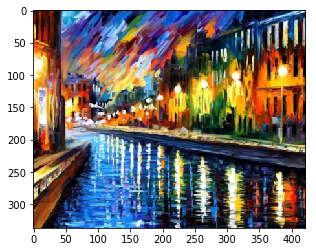

In [16]:
plt.imshow(plt.imread('../Lab3/images/styles/aqua.png'))

In [17]:
stylizer = StylizerNet()
stylizer.load_state_dict(torch.load('../Lab3/models/aqua_12.pt'))
stylizer.eval()

StylizerNet(
  (conv_block): Sequential(
    (0): ConvBlock(
      (rpad): ReflectionPad2d((4, 4, 4, 4))
      (conv): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
      (inorm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (relu): ReLU()
    )
    (1): ConvBlock(
      (rpad): ReflectionPad2d((1, 1, 1, 1))
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
      (inorm): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (relu): ReLU()
    )
    (2): ConvBlock(
      (rpad): ReflectionPad2d((1, 1, 1, 1))
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
      (inorm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (relu): ReLU()
    )
  )
  (res_block): Sequential(
    (0): ResBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (2)

In [18]:
with torch.no_grad():
    result = torch.sigmoid(stylizer(x))

In [19]:
mel = result[0]
mel = mel.numpy()
mel = mel.mean(0)

In [20]:
show(inv_melspectrogram(mel))

### Sea

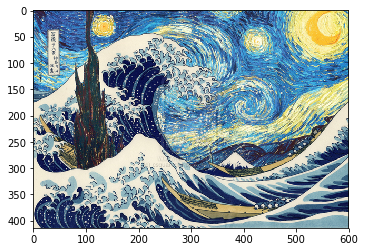

In [21]:
plt.imshow(plt.imread('../Lab3/images/styles/sea.png'))

In [22]:
stylizer = StylizerNet()
stylizer.load_state_dict(torch.load('../Lab3/models/sea_12.pt'))
stylizer.eval()

StylizerNet(
  (conv_block): Sequential(
    (0): ConvBlock(
      (rpad): ReflectionPad2d((4, 4, 4, 4))
      (conv): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
      (inorm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (relu): ReLU()
    )
    (1): ConvBlock(
      (rpad): ReflectionPad2d((1, 1, 1, 1))
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
      (inorm): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (relu): ReLU()
    )
    (2): ConvBlock(
      (rpad): ReflectionPad2d((1, 1, 1, 1))
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
      (inorm): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (relu): ReLU()
    )
  )
  (res_block): Sequential(
    (0): ResBlock(
      (block): Sequential(
        (0): ReflectionPad2d((1, 1, 1, 1))
        (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
        (2)

In [23]:
with torch.no_grad():
    result = torch.sigmoid(stylizer(x))

In [24]:
mel = result[0]
mel = mel.numpy()
mel = mel.mean(0)

In [25]:
show(inv_melspectrogram(mel))